# Computational Social Science Project #2 

**Enter your Name:** Xiaoxue Zhao

*Semester:* Fall 2024


Below we fill in some of the code you might use to answer some of the questions. Here are some additional resources for when you get stuck:
* Code and documentation provided in the course notebooks  
* [Markdown cheatsheet](https://github.com/adam-p/markdown-here/wiki/Markdown-Cheatsheet) to help with formatting the Jupyter notebook
* Try Googling any errors you get and consult Stack Overflow, etc. Someone has probably had your question before!
* Send me a pull request on GitHub flagging the syntax that's tripping you up 

**INSTRUCTIONS:** For this project, copy all of the files in the Project 2 folder in the course repo into a "Project 2" subfolder within the "Computational Social Science Projects" directory that you created for the first project. You will work on the project locally, push your project to GitHub, and submit a link to the GitHub repo on bCourses by the project deadline. Be sure the final submission is in the main branch, which is what I'll pull down and re-run to grade. 

## 1. Introduction/Setup

#### a) Import relevant libraries
Here are some libraries you will need to get started. Along the way you may need to add more. Best practice is to add them here at the top of the script.

In [1]:
!pip install statsmodels

In [2]:
#
# import libraries you might need here 
#-----------
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import plotly.express as px
import plotly.io as pio
from IPython.display import HTML

from sklearn.linear_model import Ridge, Lasso, LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import make_scorer, mean_squared_error


from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.feature_selection import RFE

pio.renderers.default = 'notebook'

sns.set_style("darkgrid")

# use random seed for consistent results 
np.random.seed(273)

#### b) Read in and inspect data frame 
Read in the data frame and look at some of its attributes. Read in the data contained in the projoect folder: "Diabetes with Population Info by County 2017.csv".

In [3]:
#
# read in and inspect data frame
#-----------
# Note that "CountyFips" needs to be a string so the leading 0 isn't dropped (only if you want to make choropleth map) 
diabetes = pd.read_csv('/Users/zxx/Documents/git/SOCIOL273L/Computational-Social-Science-Projects/Project 2/Diabetes with Population Info by County 2017.csv', 
                       dtype={"CountyFIPS": str}) 

In [4]:
#
# look at shape
#-----------
# look at the dimensions of the diabetes data frame
print('shape: ', diabetes.shape) 

shape:  (3220, 95)


In [5]:
#
# set pandas parameters
#-----------
# tells pandas how many rows to display when printing so results don't get truncated
pd.set_option('display.max_rows', 100)

# look at the data types for each column in diabetes df (likely be located under each row bc column names are long)
print('data types:', diabetes.dtypes)

data types: County                                                                                                                                                   object
State                                                                                                                                                    object
CountyFIPS                                                                                                                                               object
Diabetes_Number                                                                                                                                          object
Obesity_Number                                                                                                                                           object
Physical_Inactivity_Number                                                                                                                               object
sex and age_total population

Immediately, we see that some of the features that should be numeric (e.g., Diabetes_Number, Obesity_Number,  and Physical_Inactivity_Number) are not. We can check to see what the non-numeric values are in a column where we are expecting numeric information with a combination of `str.isnumeric()` and `unique()`.

In [6]:
#
# identify non-numeric features
#-----------
# Return rows where the column "Diabetes_Number" is non-numeric and get the unique values of these rows
# the "~" below in front of diabetes negates the str.isnumeric() so it only takes non-numeric values
print(diabetes[~diabetes["Diabetes_Number"].str.isnumeric()]["Diabetes_Number"].unique()) 

['Suppressed']


In [7]:
#
# Now do the same as above, but for "Obesity_Number"
#-----------
print(diabetes[~diabetes["Obesity_Number"].str.isnumeric()]["Obesity_Number"].unique()) 

['No Data']


In [8]:
#
# Now do the same as above, but for "Physical_Inactivity_Number" 
#-----------
print(diabetes[~diabetes["Physical_Inactivity_Number"].str.isnumeric()]["Physical_Inactivity_Number"].unique()) 

['No Data']


These values ("Suppresssed" and "No Data") contained in the two respective columns are coercing these features to objects instead of them being  integers. Let's drop those rows in the next section, and also recode "Physical_Inactivity_Number" feature to be an integer.

#### c. Recode variables

Convert 'Diabetes_Number', 'Obesity_Number', and 'Physical_Inactivity_Number' to integers below so we can use them in our analysis. Also fill in the object type we want to recode 'sex and age_total population_65 years and over_sex ratio (males per 100 females)' too (you'll have to scroll all the way over to the right).

In [9]:
#
# Recode variables
#-----------

# Diabetes
# ----------
# keep only useful info about our target feature, i.e., where diabetes_number not = 'Suppressed'
# note that the inside reference to the diabetes df identifies the column, and the outer calls specific rows according to a condition 
diabetes = diabetes[diabetes['Diabetes_Number']!="Suppressed"] 

# use the astype method on Diabetes_Number to convert it to an integer...if you are not sure, what does the astype() documentation tell you are possible arguments? 
diabetes['Diabetes_Number'] = diabetes['Diabetes_Number'].astype(int) 

# Obesity
# ----------
diabetes = diabetes[diabetes['Obesity_Number']!="No Data"] 
diabetes['Obesity_Number'] = diabetes['Obesity_Number'].astype(int) 

# Physical Inactivity
# ----------
diabetes = diabetes[diabetes['Obesity_Number']!="No Data"] 
diabetes['Physical_Inactivity_Number'] = diabetes['Physical_Inactivity_Number'].astype(int) 


# Some final changes 
# ----------
# 65+ sex ratio had one "-" in it so let's drop that row first
diabetes = diabetes[diabetes['sex and age_total population_65 years and over_sex ratio (males per 100 females)']!= "-"]

# change to numeric from string, since it originally included the "-", which made it a string
# you'll have to decide whether to make it integer or float 
diabetes['sex and age_total population_65 years and over_sex ratio (males per 100 females)'] = diabetes['sex and age_total population_65 years and over_sex ratio (males per 100 females)'].astype(float)

We should probably scale our count variables to be proportional to county population. We create the list 'rc_cols' to select all the features we want to rescale, and then use the `.div()` method to avoid typing out every single column we want to recode. 

In [10]:
#
# Scale to county populations
#-----------

# select count variables to recode to percentages; make sure we leave out ratios and our population variable 
# because these don't make sense to scale by population
rc_cols = [col for col in diabetes.columns if col not in ['County', 'State', 'CountyFIPS', 
                                                        'sex and age_total population_65 years and over_sex ratio (males per 100 females)', 
                                                        'sex and age_total population_sex ratio (males per 100 females)', 
                                                        'sex and age_total population_18 years and over_sex ratio (males per 100 females)',  
                                                        'race_total population']]
           
# recode all selected columns to numeric
diabetes[rc_cols] = diabetes[rc_cols].apply(pd.to_numeric, errors='coerce') 

# divide all columns but those listed above by total population to calculate rates
diabetes[rc_cols] = diabetes[rc_cols].div(diabetes['race_total population'], axis=0)


Let's check our work. Are all rates bounded by 0 and 1 as expected? 

In [11]:
#
# check
#-----------
# set pandas options
pd.set_option('display.max_columns', None)

# inspect recoded values
diabetes_summary = diabetes.describe().transpose() # note we use the transpose method rather than .T because this object is not a numpy array
  
# check recoding 
with pd.option_context('display.max_rows', 100, 'display.max_columns', None): 
    display(diabetes_summary.iloc[ : ,[0,1,3,7]]) # select which columns in the summary table we want to present

count           mean  \
Diabetes_Number                                     3112.0       0.092857   
Obesity_Number                                      3112.0       0.251666   
Physical_Inactivity_Number                          3112.0       0.200861   
sex and age_total population_65 years and over_...  3112.0      84.275643   
race_total population                               3112.0  103682.624036   
race_total population_one race                      3112.0       0.976059   
race_total population_two or more races             3112.0       0.023941   
race_total population_one race_1                    3112.0       0.976059   
race_total population_one race_white                3112.0       0.831107   
race_total population_one race_black or african...  3112.0       0.090215   
race_total population_one race_american indian ...  3112.0       0.019398   
race_total population_one race_american indian ...  3112.0       0.001791   
race_total population_one race_american indian ...  3112.0       0.001338   
race_total population_one race_american indian ...  3112.0       0.001229   
race_total population_one race_american indian ...  3112.0       0.003315   
race_total population_one race_asian                3112.0       0.013749   
race_total population_one race_asian_asian indian   3112.0       0.002628   
race_total population_one race_asian_chinese        3112.0       0.002644   
race_total population_one race_asian_filipino       3112.0       0.002744   
race_total population_one race_asian_japanese       3112.0       0.000707   
race_total population_one race_asian_korean         3112.0       0.001174   
race_total population_one race_asian_vietnamese     3112.0       0.001255   
race_total population_one race_asian_other asian    3112.0       0.002598   
race_total population_one race_native hawaiian ...  3112.0       0.000874   
race_total population_one race_native hawaiian ...  3112.0       0.000303   
race_total population_one race_native hawaiian ...  3112.0       0.000142   
race_total population_one race_native hawaiian ...  3112.0       0.000134   
race_total population_one race_native hawaiian ...  3112.0       0.000295   
race_total population_one race_some other race      3112.0       0.020716   
race_total population_two or more races_1           3112.0       0.023941   
race_total population_two or more races_white a...  3112.0       0.006444   
race_total population_two or more races_white a...  3112.0       0.008618   
race_total population_two or more races_white a...  3112.0       0.003021   
race_total population_two or more races_black o...  3112.0       0.000652   
race alone or in combination with one or more o...  3112.0       1.000000   
race alone or in combination with one or more o...  3112.0       0.852907   
race alone or in combination with one or more o...  3112.0       0.098875   
race alone or in combination with one or more o...  3112.0       0.029923   
race alone or in combination with one or more o...  3112.0       0.018213   
race alone or in combination with one or more o...  3112.0       0.002067   
race alone or in combination with one or more o...  3112.0       0.023626   
hispanic or latino and race_total population        3112.0       1.000000   
hispanic or latino and race_total population_hi...  3112.0       0.093201   
hispanic or latino and race_total population_hi...  3112.0       0.069331   
hispanic or latino and race_total population_hi...  3112.0       0.005656   
hispanic or latino and race_total population_hi...  3112.0       0.001568   
hispanic or latino and race_total population_hi...  3112.0       0.016645   
hispanic or latino and race_total population_no...  3112.0       0.906799   
hispanic or latino and race_total population_no...  3112.0       0.765065   
hispanic or latino and race_total population_no...  3112.0       0.088817   
hispanic or latino and race_total population_no...  3112.0       0.018016   
hispanic or latino and race_total population_no..

#### d. Check for duplicate columns

There are a lot of columns in this data frame. Let's see if there are any are duplicates. Note that Pandas will not allow them to have the same exact column name, so they will likely be distinct on column name but will be copies otherwise.

In [12]:
#
# Check for duplicate columns
#-----------
# I used Google to figure this out, and adapted this example for our purposes:  
# source: https://thispointer.com/how-to-find-drop-duplicate-columns-in-a-dataframe-python-pandas/ 
def getDuplicateColumns(df):
    '''
    Get a list of duplicate columns.
    It will iterate over all the columns in dataframe and find the columns whose contents are duplicate.
    :param df: Dataframe object
    :return: List of columns whose contents are duplicates.
    '''
    duplicateColumnNames = set()
    # Iterate over all the columns in dataframe
    for x in range(df.shape[1]):
        # Select column at xth index.
        col = df.iloc[:, x]
        # Iterate over all the columns in DataFrame from (x+1)th index till end
        for y in range(x + 1, df.shape[1]):
            # Select column at yth index.
            otherCol = df.iloc[:, y]
            # Check if two columns at x 7 y index are equal
            if col.equals(otherCol):
                duplicateColumnNames.add(df.columns.values[y])
    return list(duplicateColumnNames)

duplicateColumnNames = list(getDuplicateColumns(diabetes))
print('Duplicate Columns are as follows: ')
duplicateColumnNames

Duplicate Columns are as follows: 


['sex and age_total population',
 'race_total population_one race_1',
 'sex and age_total population_65 years and over_1',
 'hispanic or latino and race_total population',
 'race_total population_two or more races_1',
 'sex and age_total population_18 years and over_1']

In [13]:
#
# drop columns from duplicates list
#-----------
# now drop list of duplicate features from our df using the .drop() method
diabetes = diabetes.drop(columns=duplicateColumnNames) 

Finally, there are many states accounted for the in dataset. If we convert this column to a categorical variable, and create dummies, it will create a rather sparse matrix (many 0s in our dataset) becuase there will be 49 dummy variables. One alternative is to classify each state to a larger US region and use that variable instead of state. The following code will do that.

In [14]:
# Define a dictionary mapping states to regions
state_to_region = {
    'Alabama': 'Southeast',
    'Alaska': 'West',
    'Arizona': 'West',
    'Arkansas': 'South',
    'California': 'West',
    'Colorado': 'West',
    'Connecticut': 'Northeast',
    'Delaware': 'Northeast',
    'District of Columbia': 'Southeast',
    'Florida': 'Southeast',
    'Georgia': 'Southeast',
    'Hawaii': 'West',
    'Idaho': 'West',
    'Illinois': 'Midwest',
    'Indiana': 'Midwest',
    'Iowa': 'Midwest',
    'Kansas': 'Midwest',
    'Kentucky': 'South',
    'Louisiana': 'South',
    'Maine': 'Northeast',
    'Maryland': 'Northeast',
    'Massachusetts': 'Northeast',
    'Michigan': 'Midwest',
    'Minnesota': 'Midwest',
    'Mississippi': 'South',
    'Missouri': 'Midwest',
    'Montana': 'West',
    'Nebraska': 'Midwest',
    'Nevada': 'West',
    'New Hampshire': 'Northeast',
    'New Jersey': 'Northeast',
    'New Mexico': 'West',
    'New York': 'Northeast',
    'North Carolina': 'Southeast',
    'North Dakota': 'Midwest',
    'Ohio': 'Midwest',
    'Oklahoma': 'South',
    'Oregon': 'West',
    'Pennsylvania': 'Northeast',
    'Rhode Island': 'Northeast',
    'South Carolina': 'Southeast',
    'South Dakota': 'Midwest',
    'Tennessee': 'South',
    'Texas': 'South',
    'Utah': 'West',
    'Vermont': 'Northeast',
    'Virginia': 'Southeast',
    'Washington': 'West',
    'West Virginia': 'South',
    'Wisconsin': 'Midwest',
    'Wyoming': 'West'
}

# Add a new 'Region' column based on the mapping
diabetes['Region'] = diabetes['State'].map(state_to_region)

# Print to verify'Region' column has been added
diabetes
# diabetes.to_csv('/Users/zxx/Documents/git/SOCIOL273L/Computational-Social-Science-Projects/Project 2/Diabetes_Cleaned.csv',index=False)

County    State CountyFIPS  Diabetes_Number  Obesity_Number  \
0        Autauga County  Alabama      01001         0.093804        0.244366   
1        Baldwin County  Alabama      01003         0.080281        0.233255   
2        Barbour County  Alabama      01005         0.131875        0.310643   
3           Bibb County  Alabama      01007         0.105251        0.290052   
4         Blount County  Alabama      01009         0.108977        0.246804   
...                 ...      ...        ...              ...             ...   
3215  Sweetwater County  Wyoming      56037         0.058028        0.212208   
3216       Teton County  Wyoming      56039         0.019038        0.088946   
3217       Uinta County  Wyoming      56041         0.069872        0.238973   
3218    Washakie County  Wyoming      56043         0.078361        0.213802   
3219      Weston County  Wyoming      56045         0.084648        0.283803   

      Physical_Inactivity_Number  \
0                       0.226902   
1                       0.192324   
2                       0.210651   
3                       0.258667   
4                       0.249198   
...                          ...   
3215                    0.170410   
3216                    0.086951   
3217                    0.170751   
3218                    0.210112   
3219                    0.194789   

      sex and age_total population_65 years and over_sex ratio (males per 100 females)  \
0                                                  76.5                                  
1                                                  86.6                                  
2                                                  76.2                                  
3                                                  80.5                                  
4                                                  79.7                                  
...                                                 ...                                  
3215                                               92.0                                  
3216                                               94.8                                  
3217                                               97.6                                  
3218                                               89.0                                  
3219                                               90.6                                  

      race_total population  race_total population_one race  \
0                     55200                        0.981341   
1                    208107                        0.982836   
2                     25782                        0.986308   
3                     22527                        0.991699   
4                     57645                        0.983780   
...                     ...                             ...   
3215                  44117                        0.979804   
3216                  23059                        0.992020   
3217                  20609                        0.965161   
3218                   8129                        0.958420   
3219                   7100                        0.979718   

      race_total population_two or more races  \
0                                    0.018659   
1                                    0.017164   
2                                    0.013692   
3                                    0.008301   
4                                    0.016220   
...                                       ...   
3215                                 0.020196   
3216                                 0.007980   
3217                                 0.034839   
3218                                 0.041580   
3219                                 0.020282   

      race_total population_one race_white  \
0                                 0.768786   
1                                 0.862662   
2                                 0.473819   
3           

## 2. Exploratory Data Analysis

Make at least two figures (feel free to make more) and explain their relevance to the scientific problem. The goal here is to uncover interesting patterns in the data, learn more about the scope of the problem, and communicate these findings to your audience in clear ways.

In [15]:
!pip install plotly

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt

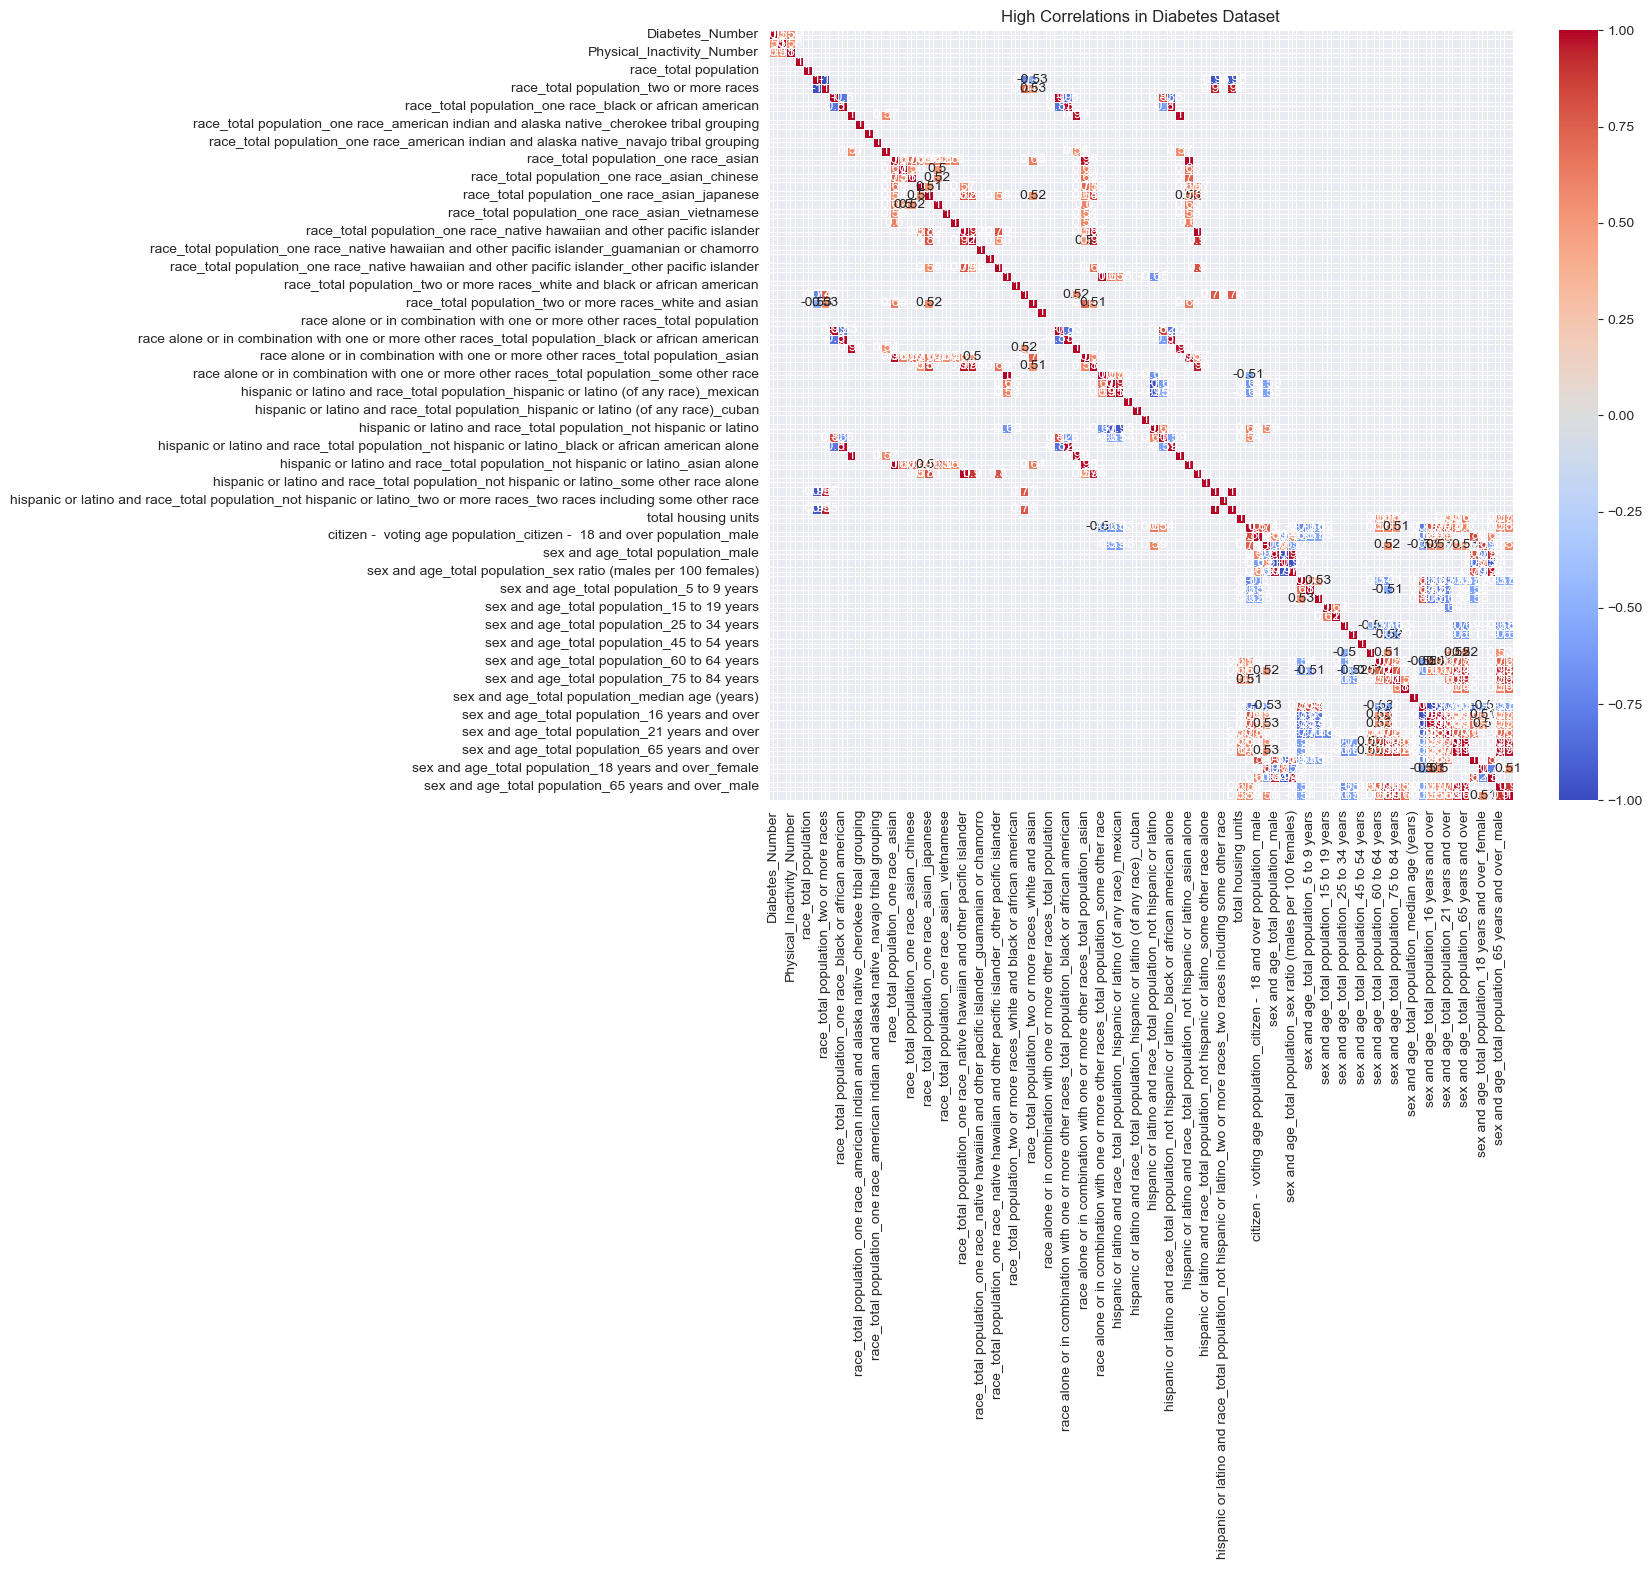

In [17]:
# Set a correlation threshold (e.g., only show correlations > 0.5 or < -0.5)
correlation_threshold = 0.5

# Calculate the correlation matrix for numeric columns
corr_matrix = diabetes.select_dtypes(include='number').corr()

# Filter the correlation matrix
high_corr_matrix = corr_matrix[(corr_matrix > correlation_threshold) | (corr_matrix < -correlation_threshold)]

# Set the size of the figure
plt.figure(figsize=(12, 10))

# Create a heatmap using seaborn
sns.heatmap(high_corr_matrix, annot=True, cmap='coolwarm', center=0, linewidths=0.5)

# Set the title
plt.title('High Correlations in Diabetes Dataset')

# Display the heatmap
plt.show()

**Analysis:** 
- High Positive Correlations
    - Red areas indicate strong positive correlations. For instance, Obesity_Number and Physical_Inactivity_Number are highly correlated, which is expected as obesity and physical inactivity are often linked.
    - Similar correlations are seen among demographic variables, such as different racial or age group proportions, which often describe overlapping populations.
- High Negative Correlations
    - Blue areas show negative correlations, often between complementary features. For example, a higher proportion of one racial group may correspond to a lower proportion of another.
- Multicollinearity
    - High correlations indicate potential multicollinearity, which can affect model stability and interpretability. To address this, feature selection or regularization techniques like Ridge or Lasso should be used.

### EDA #1 Spatial Clustering
**Description**: Spatial clustering analysis helps reveal geographic variations in diabetes rates across U.S. counties. It identifies high and low prevalence clusters, highlighting regional health disparities, access to care, and socioeconomic factors. This choropleth map aids in targeting interventions and public health strategies.

In [18]:
#
# EDA #1 and interpretations in this section 
#-----------
diabetes['CountyFIPS'] = diabetes['CountyFIPS'].astype(str)
print(diabetes['CountyFIPS'].head())

0    01001
1    01003
2    01005
3    01007
4    01009
Name: CountyFIPS, dtype: object


In [19]:
import json
import requests

# Load GeoJSON for U.S. counties
url = 'https://raw.githubusercontent.com/plotly/datasets/master/geojson-counties-fips.json'
response = requests.get(url)
counties_geojson = json.loads(response.text)

# Extract FIPS codes from the GeoJSON file
geojson_fips = {feature['id'] for feature in counties_geojson['features']}

# Find unmatched FIPS codes in your dataset
unmatched_fips = set(diabetes['CountyFIPS']) - geojson_fips

print(f"Number of unmatched FIPS codes: {len(unmatched_fips)}")
print(unmatched_fips)

Number of unmatched FIPS codes: 2
{'02158', '46102'}


In [20]:
diabetes_filtered = diabetes[~diabetes['CountyFIPS'].isin({'02158', '46102'})]

In [21]:
# Create a choropleth map using Plotly
fig = px.choropleth(
    diabetes_filtered,
    geojson='https://raw.githubusercontent.com/plotly/datasets/master/geojson-counties-fips.json',
    locations='CountyFIPS',
    featureidkey='id',
    color='Diabetes_Number',
    color_continuous_scale='Reds',
    scope='usa',
    labels={'Diabetes_Number': 'Diabetes Rate'},
    hover_name='County',
    hover_data=['State', 'Diabetes_Number'],
    range_color=(0, diabetes_filtered['Diabetes_Number'].max())
)

# Update the layout for better visualization
fig.update_layout(
    title_text='Choropleth Map of Diabetes Rates Across U.S. Counties',
    title_x=0.5,
    margin={"r":0,"t":50,"l":0,"b":0}
)

HTML(fig.to_html())

**Interpretation of Spatial Distribution**  
The result presents a significant spatial clustering of county-level diabetes prevalence in the United States.  
- Regional Clusters of High Rates:
	- Higher diabetes rates are observed in the Southeast and parts of the Southwest. This clustering aligns with known “Diabetes Belt” regions, where socioeconomic conditions, limited access to healthcare, and lifestyle factors contribute to higher diabetes prevalence.
- Regions with Lower Rates:
	- Lower diabetes rates are generally found in the Northeast and West Coast, possibly due to better healthcare access, higher education levels, and healthier lifestyle habits prevalent in these areas.
- Implications for Interventions:
	- The distribution highlights the need to understand local context in the prevention and maintenance of diabetes, such as increased access to healthcare services, community-based programs for diabetes management, and initiatives to promote healthier lifestyles.

### EDA #2 Proportion of Different Races vs. Diabetes Rate

In [22]:
#
# EDA #2 and interpretations in this section 
#-----------

race_columns = [
    'race_total population_one race_white',
    'race_total population_one race_black or african american',
    'race_total population_one race_asian',
    'race_total population_one race_american indian and alaska native'
]


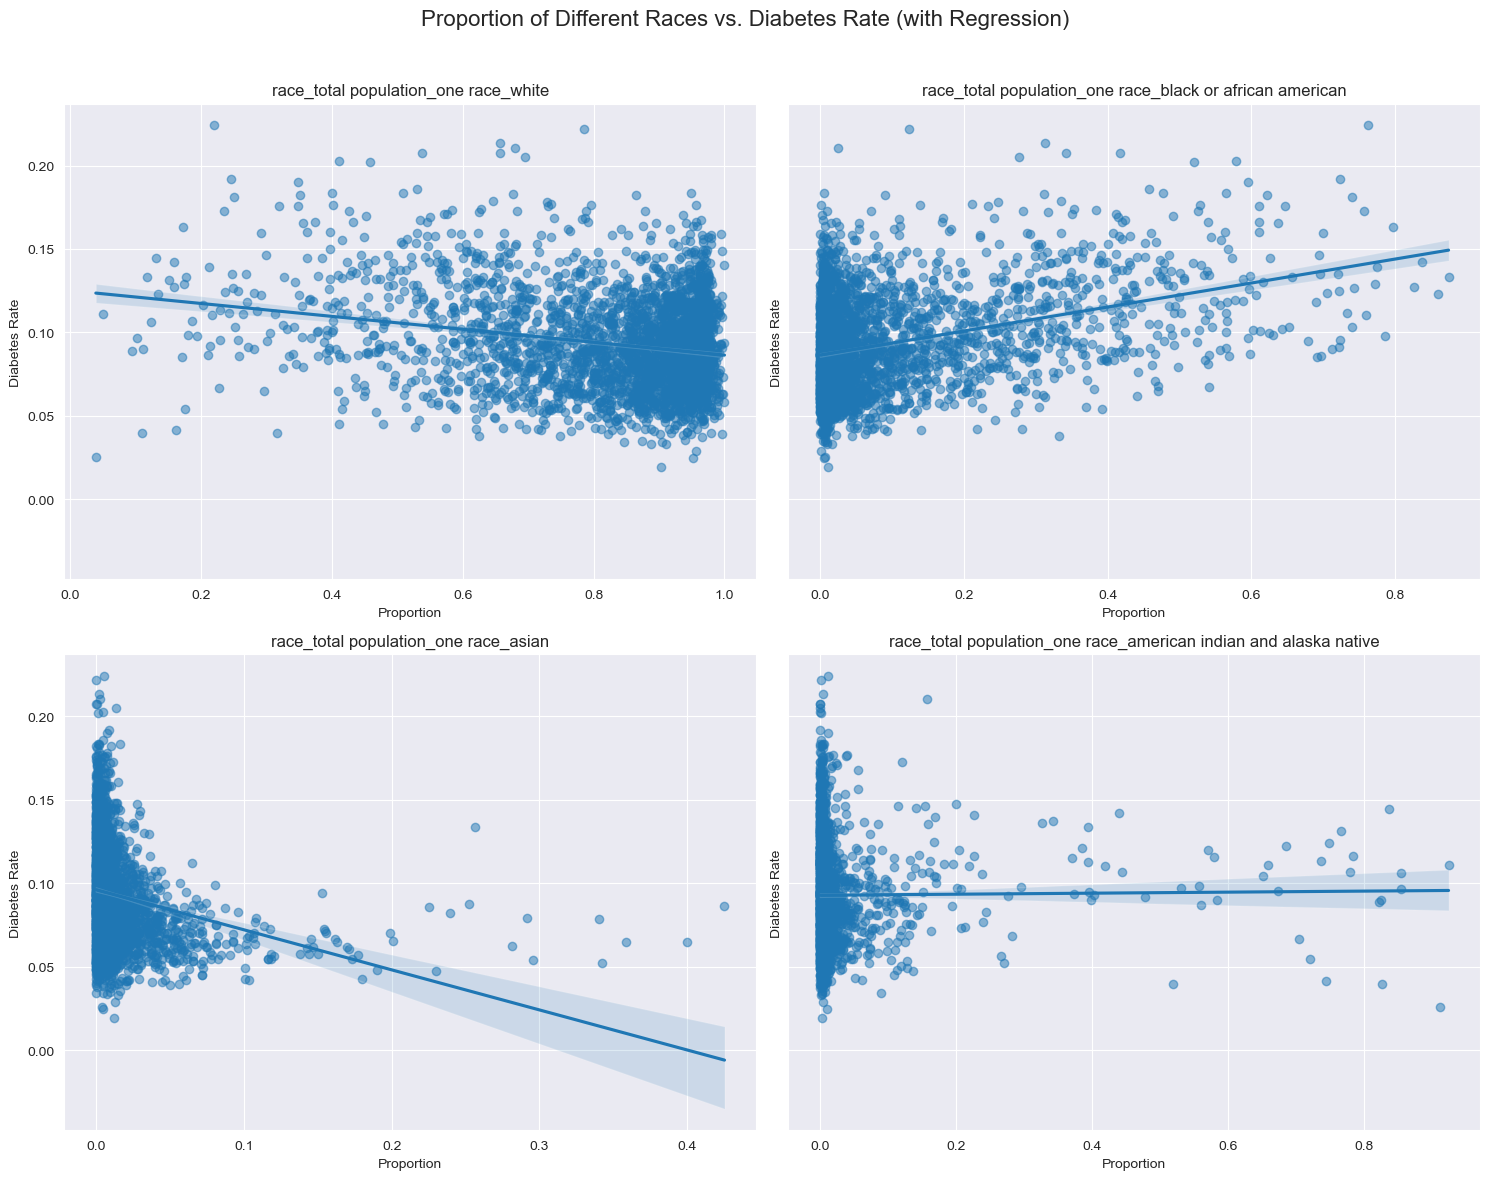

In [23]:
fig, axes = plt.subplots(2, 2, figsize=(15, 12), sharey=True)
fig.suptitle('Proportion of Different Races vs. Diabetes Rate (with Regression)', fontsize=16)

# 遍历种族变量，绘制回归图
for i, race in enumerate(race_columns):
    row, col = divmod(i, 2)
    sns.regplot(data=diabetes, x=race, y='Diabetes_Number', scatter_kws={'alpha': 0.5}, ax=axes[row, col])
    axes[row, col].set_title(f'{race}')
    axes[row, col].set_xlabel('Proportion')
    axes[row, col].set_ylabel('Diabetes Rate')

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

**Interpretation of Proportion of Different Races vs. Diabetes Rate**
- White Population Proportion
    - There is a slight downward trend, suggesting that as the proportion of the white population increases, the diabetes rate slightly decreases. However, the relationship is weak and not highly significant, indicating that other factors might also play a crucial role in determining diabetes rates in these areas.
- Black or African American Population Proportion
    - There is a clear upward trend. Counties with a higher proportion of Black or African American residents tend to have higher diabetes rates. This suggests a stronger positive correlation compared to other racial groups, implying that diabetes rates might be more prevalent in predominantly Black or African American areas.
- Asian Population Proportion
    - The trend line is slightly negative, indicating that counties with a higher proportion of Asians tend to have slightly lower diabetes rates. The spread of the data is quite wide, suggesting that the correlation is not particularly strong and may be influenced by other factors.
- American Indian and Alaska Native Population Proportion
    - There is a mild upward trend, but it is less pronounced than in the Black or African American group. The relationship indicates a potential increase in diabetes rates as the proportion of American Indian and Alaska Native populations rises, but with a more modest impact.

## 3. Prepare to Fit Models

### 3.1 Finalize Data Set

We've already cleaned up the data, but we can make a few more adjustments before partitioning the data and training models. Let's recode 'Region' to be a categorical variable using `pd.get_dummies` and drop 'State'. Also, we'll drop 'County' because 'CountyFIPS' is already a unique identifier for the county. 

In [24]:
#
# Drop and get dummies
#-----------

# create dummy features out of 'Region', which might be related to diabetes rates 
diabetes_clean = pd.get_dummies(data = diabetes, 
                               columns = ['Region'],  
                               drop_first = True) # drop the first as a reference 

# drop 'County' and 'State' variables
diabetes_clean = diabetes_clean.drop(labels = ['County', 'State'],
                               axis = 1)

# look at first 10 rows of new data frame 
diabetes_clean.head(10)

CountyFIPS  Diabetes_Number  Obesity_Number  Physical_Inactivity_Number  \
0      01001         0.093804        0.244366                    0.226902   
1      01003         0.080281        0.233255                    0.192324   
2      01005         0.131875        0.310643                    0.210651   
3      01007         0.105251        0.290052                    0.258667   
4      01009         0.108977        0.246804                    0.249198   
5      01011         0.224208        0.353748                    0.321967   
6      01013         0.145318        0.349513                    0.300974   
7      01015         0.127648        0.298580                    0.234140   
8      01017         0.141518        0.324425                    0.220570   
9      01019         0.122848        0.300429                    0.237342   

   sex and age_total population_65 years and over_sex ratio (males per 100 females)  \
0                                               76.5                                  
1                                               86.6                                  
2                                               76.2                                  
3                                               80.5                                  
4                                               79.7                                  
5                                               73.6                                  
6                                               69.1                                  
7                                               73.7                                  
8                                               73.3                                  
9                                               86.7                                  

   race_total population  race_total population_one race  \
0                  55200                        0.981341   
1                 208107                        0.982836   
2                  25782                        0.986308   
3                  22527                        0.991699   
4                  57645                        0.983780   
5                  10352                        1.000000   
6                  20025                        0.983870   
7                 115098                        0.976229   
8                  33826                        0.989742   
9                  25853                        0.991955   

   race_total population_two or more races  \
0                                 0.018659   
1                                 0.017164   
2                                 0.013692   
3                                 0.008301   
4                                 0.016220   
5                                 0.000000   
6                                 0.016130   
7                                 0.023771   
8                                 0.010258   
9                                 0.008045   

   race_total population_one race_white  \
0                              0.768786   
1                              0.862662   
2                              0.473819   
3                              0.766547   
4                              0.955052   
5                              0.219861   
6                              0.520050   
7                              0.743349   
8                              0.575977   
9                              0.928209   

   race_total population_one race_black or african american  \
0                                           0.191395          
1                                           0.094970          
2                                           0.475758          
3                                           0.222755          
4                                           0.014954          
5                                           0.762461          
6                                           0.452185          
7                                           0.2057

### 3.2 Partition Data, Feature Selection, and Standardization

Now, we will partition our data to prepare it for the training process. Ultimately we want to use a 60% train—20% validation—20% test in this case. More data in the training set lowers bias, but then increases variance in the validation/test sets. Balancing between bias and variance with choice of these set sizes is important as we want to ensure that there is enough data to train on to get good predictions, but also want to make sure our hold-out sets are representative enough.

Work through partitioning the data into the test/train/validation sets in the chunks below. Be sure to that if you are using Ridge or LASSO, you Standardize the data. Where you do this in the workflow matters so be clear about where you are doing this and why. 

In [25]:
#
# Partition data
#-----------

# import library
from sklearn.model_selection import train_test_split

# create y dataframe 
y = diabetes_clean.Diabetes_Number

# create X dataframe (include everything except "Diabetes_Number", our target, 
# and "race alone or in combination with one or more other races_total population")
X = diabetes_clean.drop(labels = ['Diabetes_Number',
                                  'race alone or in combination with one or more other races_total population'],
                               axis = 1)

In [26]:
print(X.shape)
print(y.shape)

(3112, 89)
(3112,)


Investigate whether there are any features that you should remove prior to spliting and model fitting. You may also consider using plots and relationships you found in the EDA stage for this question. Be sure to justify your logic. 

In [27]:
#
# Feature selection
#-----------
from sklearn.feature_selection import VarianceThreshold

# Step 1: Apply variance threshold to the feature set X
variance_threshold = 0.001  # Define the variance threshold
selector = VarianceThreshold(threshold=variance_threshold)
selector.fit(X)

# Step 2: Get the names of the selected features
selected_features = X.columns[selector.get_support()]

# Step 3: Create a new DataFrame with only the selected features
X_selected = X[selected_features]

# Display the shape and first few rows of the new DataFrame
print(f"Shape of the dataset with selected features: {X_selected.shape}")
X_selected.head()

Shape of the dataset with selected features: (3112, 38)


CountyFIPS  Obesity_Number  Physical_Inactivity_Number  \
0      01001        0.244366                    0.226902   
1      01003        0.233255                    0.192324   
2      01005        0.310643                    0.210651   
3      01007        0.290052                    0.258667   
4      01009        0.246804                    0.249198   

   sex and age_total population_65 years and over_sex ratio (males per 100 females)  \
0                                               76.5                                  
1                                               86.6                                  
2                                               76.2                                  
3                                               80.5                                  
4                                               79.7                                  

   race_total population  race_total population_one race_white  \
0                  55200                              0.768786   
1                 208107                              0.862662   
2                  25782                              0.473819   
3                  22527                              0.766547   
4                  57645                              0.955052   

   race_total population_one race_black or african american  \
0                                           0.191395          
1                                           0.094970          
2                                           0.475758          
3                                           0.222755          
4                                           0.014954          

   race_total population_one race_american indian and alaska native  \
0                                           0.002880                  
1                                           0.007314                  
2                                           0.002793                  
3                                           0.000355                  
4                                           0.002446                  

   race_total population_one race_american indian and alaska native_sioux tribal grouping  \
0                                           0.000000                                        
1                                           0.000072                                        
2                                           0.000000                                        
3                                           0.000000                                        
4                                           0.000000                                        

   race_total population_one race_some other race  \
0                                        0.007409   
1                                        0.009774   
2                                        0.030176   
3                                        0.000400   
4                                        0.007581   

   race alone or in combination with one or more other races_total population_white  \
0                                           0.785634                                  
1                                           0.877861                                  
2                                           0.483322                                  
3                                           0.774493                                  
4                                           0.971134                                  

   race alone or in combination with one or more other races_total population_black or african american  \
0                                           0.198587                                                      
1                                           0.097599                                                      
2                                           0.484524                                                      
3                                           0.227150                                  

**More Selection**
- drop 'CountyFIPS'variables
    - 'CountyFIPS' should be dropped because it is primarily an identifier representing county indexes, making it irrelevant for modeling. It does not provide meaningful information for predicting diabetes rates and can negtively impact model performance, particularly in Lasso Regression, which is highly sensitve to unnecessary or non-informative variables. 

In [28]:
# drop 'CountyFIPS'variables
X_selected = X_selected.drop(labels = ['CountyFIPS'], axis = 1)

In [29]:
X_selected.head()

Obesity_Number  Physical_Inactivity_Number  \
0        0.244366                    0.226902   
1        0.233255                    0.192324   
2        0.310643                    0.210651   
3        0.290052                    0.258667   
4        0.246804                    0.249198   

   sex and age_total population_65 years and over_sex ratio (males per 100 females)  \
0                                               76.5                                  
1                                               86.6                                  
2                                               76.2                                  
3                                               80.5                                  
4                                               79.7                                  

   race_total population  race_total population_one race_white  \
0                  55200                              0.768786   
1                 208107                              0.862662   
2                  25782                              0.473819   
3                  22527                              0.766547   
4                  57645                              0.955052   

   race_total population_one race_black or african american  \
0                                           0.191395          
1                                           0.094970          
2                                           0.475758          
3                                           0.222755          
4                                           0.014954          

   race_total population_one race_american indian and alaska native  \
0                                           0.002880                  
1                                           0.007314                  
2                                           0.002793                  
3                                           0.000355                  
4                                           0.002446                  

   race_total population_one race_american indian and alaska native_sioux tribal grouping  \
0                                           0.000000                                        
1                                           0.000072                                        
2                                           0.000000                                        
3                                           0.000000                                        
4                                           0.000000                                        

   race_total population_one race_some other race  \
0                                        0.007409   
1                                        0.009774   
2                                        0.030176   
3                                        0.000400   
4                                        0.007581   

   race alone or in combination with one or more other races_total population_white  \
0                                           0.785634                                  
1                                           0.877861                                  
2                                           0.483322                                  
3                                           0.774493                                  
4                                           0.971134                                  

   race alone or in combination with one or more other races_total population_black or african american  \
0                                           0.198587                                                      
1                                           0.097599                                                      
2                                           0.484524                                                      
3                                           0.227150                                                      
4                                           0.

In [30]:
#
# Training/test split
#-----------

# set the random seed
np.random.seed(10)


# split the data so that it returns 4 values: X_train, X_test, y_train, y_test
X_train, X_test, y_train, y_test = train_test_split(X_selected,                 # specify training dataset
                                                    y,                 # specify test dataset
                                                    train_size=0.80,      # specify proportional split for training
                                                    test_size=0.20)       # specify proportional split for test

In [31]:
#
# Validation split
#-----------

# train_test_split returns 4 values: X_train, X_test, y_train, y_test, so how do we create a 60-20-20 train-validate-test split? 
X_train, X_validate, y_train, y_validate =  train_test_split(X_train,                 # specify training dataset
                                                    y_train,                 # specify test dataset
                                                    train_size=0.75,      # specify proportional split for training
                                                    test_size=0.25)       # specify proportional split for test

In [32]:
#
# Standardization
#-----------
# Given that we want to only standardize non-dichotomous variables, we need to find a 
# solution that will loop over only the columns we want to standardize. The code below
# identifies all non-dichotomous variables in our dataset and only standardizes those.

# load library and create instance of Standard Scaler 
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()


# identify non-dichotomous columns we want to transform
columns = list(X_test.select_dtypes(include=['number']).loc[:, X_test.nunique() > 2])

# use loop to transform training data for only columns we want to transform
for column in columns:
    X_train[column] = scaler.fit_transform(X_train[column].values.reshape(-1, 1)).flatten()

# use loop to transform validation data for only columns we want to transform
for column in columns:
    X_validate[column] = scaler.fit_transform(X_validate[column].values.reshape(-1, 1)).flatten()

# use loop to transform test data for only columns we want to transform
for column in columns:
    X_test[column] = scaler.fit_transform(X_test[column].values.reshape(-1, 1)).flatten()

**Additional explanation**  

The original standardization method provided by the instructor fits the scaler separately for each dataset (training, validation, and test). However, I believe it may need adjustment to prevent potential **data leakage**. By fitting the scaler on the training data only and then using it to transform the validation and test sets, we can maintain the integrity of these hold-out sets and ensure a more realistic model evaluation. This approach avoids the risk of inadvertently introducing information from the validation or test sets into the model during scaling.

## 4. Train Models

In this section, train your models. 

**Note that if you use Lasso, you will likely need to specify a very low penalty (e.g., an alpha of 0.001) because of convergence problems.**

### 4.1 Describe models

Detail the basic logic and assumptions underlying each model, its pros/cons, and why it is a plausible choice for this problem.

**MODEL DESCRIPTION(S):** 
1. Linear Regression
- Basic Logic & Assumptions: Assumes a linear relationship between independent variables and the target. It minimizes the sum of squared residuals to find the best fit.
- Pros: Easy to interpret, fast to train, and works well with linearly separable data.
- Cons: Sensitive to outliers and multicollinearity; does not handle non-linearity well.
- Relevance: Serves as a baseline model to compare more complex methods, offering a straightforward interpretation of variable importance.
2. Ridge Regression
- Basic Logic & Assumptions: Similar to linear regression but adds a penalty to the loss function, reducing the impact of collinear variables by shrinking their coefficients.
- Pros: Addresses multicollinearity, stabilizes coefficient estimates, and improves generalization.
- Cons: Coefficients are harder to interpret due to shrinkage, and it assumes a linear relationship.
- Relevance: Suitable for handling multicollinearity in this dataset and improving model robustness.
3. Lasso Regression
- Basic Logic & Assumptions: Adds an L1 penalty to the loss function, which can reduce some coefficients to zero, effectively performing feature selection.
- Pros: Simultaneously selects important variables while fitting the model, improving interpretability.
- Cons: Can be unstable when variables are highly correlated; may discard useful features.
- Relevance: Helpful for identifying the most influential features in predicting diabetes rates and reducing model complexity.

### 4.2 Train models

Train each model in the training set, and be sure to tune hyperparameters if appropriate. Report any relevant summary statistics from the training set, including how well each model fits the training data.

#### Model 1:  Linear Regression 

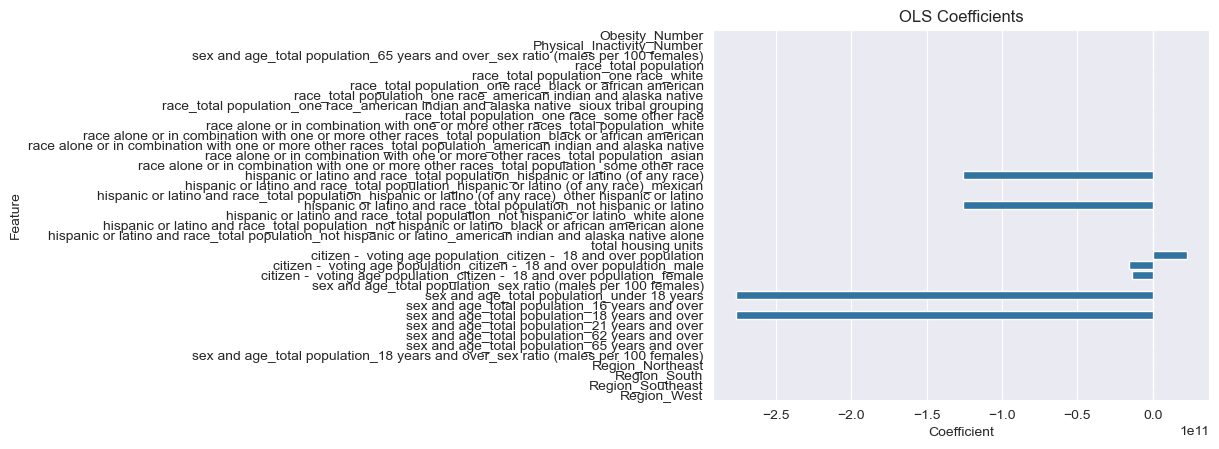

In [33]:
#
# Model 1 training
#-----------

# create a model
lin_reg = LinearRegression()

# fit the model
lin_model = lin_reg.fit(X_train, y_train)

# create a dataframe with the coefficient and feature names for plotting and plot
lin_reg_data = pd.DataFrame([lin_model.coef_, X_selected.columns]).T 
lin_reg_data.columns = ['Coefficient', 'Feature']

ax = sns.barplot(x="Coefficient",                           # add x 
                 y="Feature",                               # add y
                 data=lin_reg_data)                         # specify data

ax.set_title("OLS Coefficients")                            # set title
plt.show()                                                  # show plot

#### Model 2:  Ridge Regression

In [34]:
#
# Model 2 training
#-----------
ridge_reg = Ridge()
ridge_model = ridge_reg.fit(X_train, y_train)

ridge_reg_data = pd.DataFrame([ridge_model.coef_, X_selected.columns]).T
ridge_reg_data.columns = ['Coefficient', 'Feature']

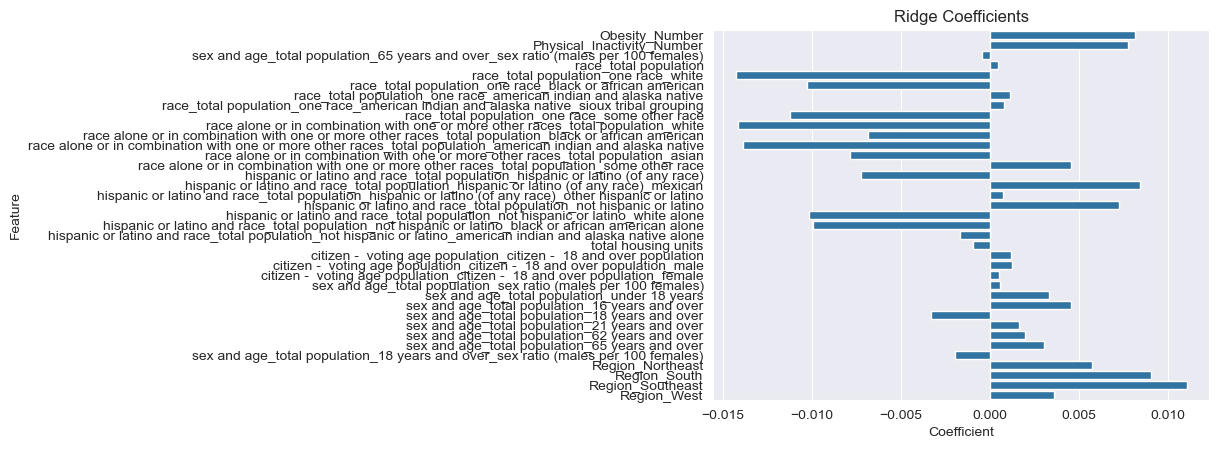

In [35]:
# plot
ax = sns.barplot(x="Coefficient",                           # add x 
                 y="Feature",                               # add y
                 data=ridge_reg_data)                         # specify data

ax.set_title("Ridge Coefficients")                            # set title

plt.show()                                                  # show plot

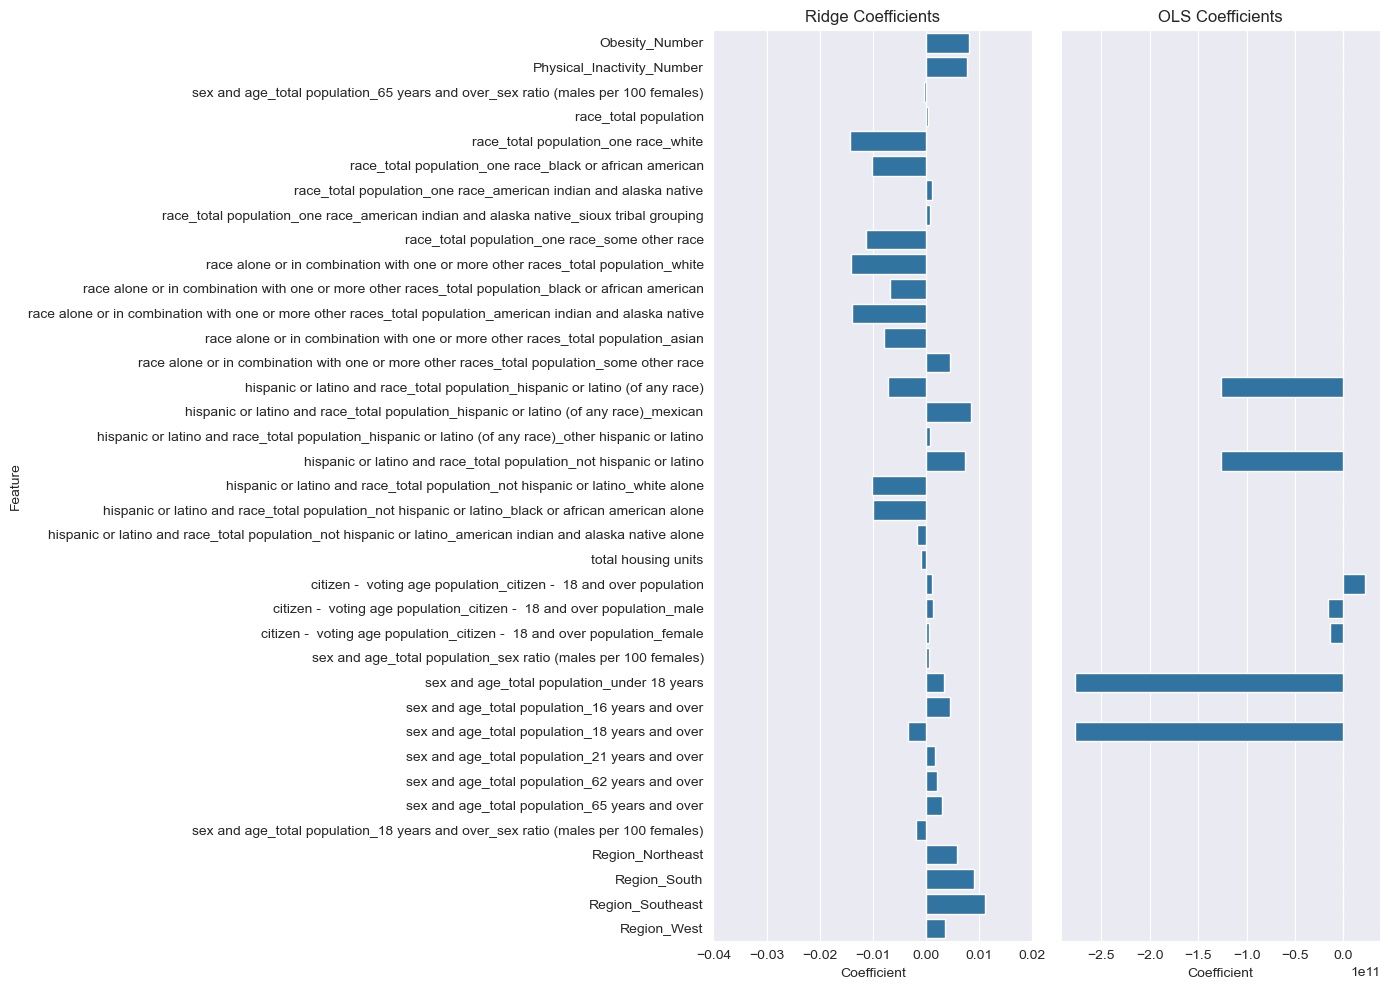

In [36]:
# create a figure with two subplots sharing the same y-axis
fig, axes = plt.subplots(1, 2, figsize=(14, 10), sharey=True)

# plot 1
sns.barplot(
    x="Coefficient", 
    y="Feature", 
    data=ridge_reg_data, 
    ax=axes[0]
).set_title("Ridge Coefficients")

# plot 2
sns.barplot(
    x="Coefficient", 
    y="Feature", 
    data=lin_reg_data, 
    ax=axes[1]
).set_title("OLS Coefficients")

axes[0].set_xlim(-0.04, 0.02)
fig.tight_layout()

plt.show()

**Analysis:** The coefficients for the Ridge regression are generally smaller.

#### Model 3:  LASSO Regression

In [37]:
#
# Model 3 training
#-----------
# create and fit the model
lasso_reg = Lasso(alpha=0.001, max_iter=15000)  # note the hypterparameter tuning will not converge with max_iter < 15000
lasso_model = lasso_reg.fit(X_train, 
                            y_train)

# create a dataframe with the coefficient and feature names for plotting
lasso_reg_data = pd.DataFrame([lasso_model.coef_, X_selected.columns]).T  
lasso_reg_data.columns = ['Coefficient', 'Feature']

In [38]:
# print model coefficients and intercept
print(lasso_model.coef_)
print(lasso_model.intercept_)

[ 7.50426989e-03  9.09129051e-03 -0.00000000e+00 -0.00000000e+00
 -0.00000000e+00  0.00000000e+00  0.00000000e+00  1.93085094e-05
 -0.00000000e+00 -2.45768828e-03  0.00000000e+00  0.00000000e+00
 -3.10071322e-04 -0.00000000e+00  0.00000000e+00  0.00000000e+00
 -5.30829115e-04 -0.00000000e+00 -0.00000000e+00  4.05016274e-03
  2.84261646e-04 -0.00000000e+00  0.00000000e+00  0.00000000e+00
  1.00209767e-03 -0.00000000e+00 -0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  3.32731337e-03
 -0.00000000e+00 -0.00000000e+00  0.00000000e+00  0.00000000e+00
 -0.00000000e+00]
0.09365835542953589


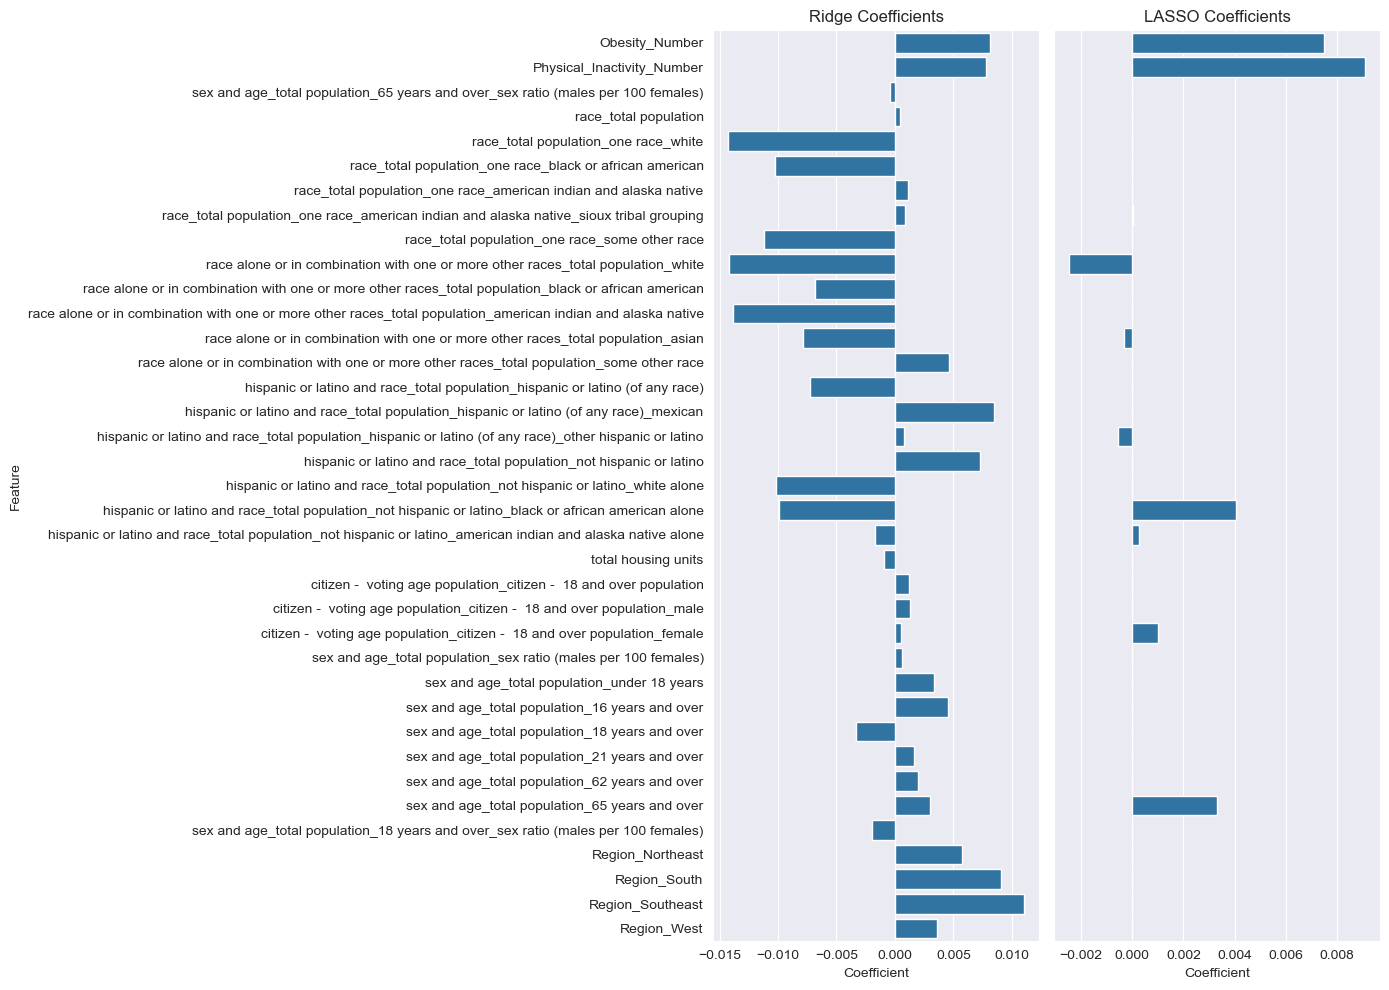

In [39]:
# create a figure with two subplots sharing the same y-axis
fig, axes = plt.subplots(1, 2, figsize=(14, 10), sharey=True)

# plot 1
sns.barplot(
    x="Coefficient", 
    y="Feature", 
    data=ridge_reg_data, 
    ax=axes[0]
).set_title("Ridge Coefficients")

# plot 2
sns.barplot(
    x="Coefficient", 
    y="Feature", 
    data=lasso_reg_data, 
    ax=axes[1]
).set_title("LASSO Coefficients")

fig.tight_layout()

plt.show()

## 5. Validate and Refine Models

### 5.1 Predict on the validation set
Using each of the models you trained, predict outcomes in the validation set. Evaluate how well each model did.

In [40]:
#
# Predict on validation data
#-----------

# create function to calculate the root mean squared errror
def rmse(pred, actual):
    return np.sqrt(np.mean((pred - actual) ** 2))

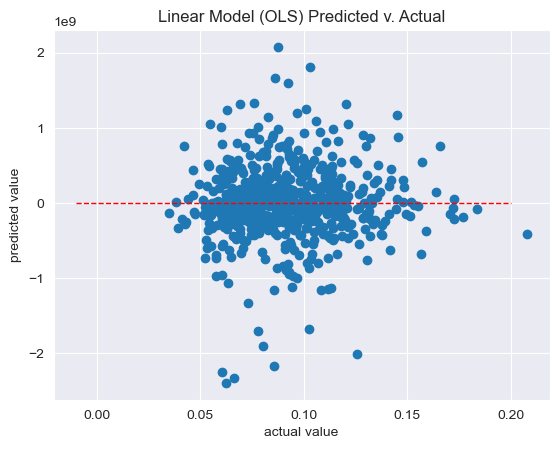

In [41]:
# evaluate the model
lin_pred = lin_model.predict(X_test)

# plot the residuals on a scatter plot
plt.scatter(y_validate, lin_pred)                    # specify x and y of the scatter plot
plt.title('Linear Model (OLS) Predicted v. Actual')  # specify plot title
plt.xlabel('actual value')                           # specify x-axis label
plt.ylabel('predicted value')                        # specify y-axis label

# add a reference line for perfect prediction
plt.plot([-0.01, 0.2], [-0.01, 0.2], color='red', linestyle='--', linewidth=1)

plt.show()                                           # show plot

In [42]:
# calculate the rmse for the Linear model
rmse(lin_pred, y_validate)

497434067.14698946

**Analysis:**  

Based on the scatter plot results, there is a possibility that high multicollinearity among the variables might be affecting the model’s performance, though this is only a hypothesis at this stage. 

To investigate further, I implemented Recursive Feature Elimination (RFE) to identify and retain the most important features, which could help reduce redundancy and potentially improve the model’s accuracy. After applying RFE, I retrained the model and assessed its performance again to confirm whether multicollinearity was indeed a contributing factor.

In [43]:
# Implementing RFE
rfe = RFE(lin_reg, n_features_to_select=20)
X_rfe = rfe.fit_transform(X_selected, y)

selected_features_rfe = X_selected.columns[rfe.support_]

print(f"Selected features after RFE: {selected_features}")
X_selected_rfe = X_selected[selected_features_rfe]

Selected features after RFE: Index(['CountyFIPS', 'Obesity_Number', 'Physical_Inactivity_Number',
       'sex and age_total population_65 years and over_sex ratio (males per 100 females)',
       'race_total population', 'race_total population_one race_white',
       'race_total population_one race_black or african american',
       'race_total population_one race_american indian and alaska native',
       'race_total population_one race_american indian and alaska native_sioux tribal grouping',
       'race_total population_one race_some other race',
       'race alone or in combination with one or more other races_total population_white',
       'race alone or in combination with one or more other races_total population_black or african american',
       'race alone or in combination with one or more other races_total population_american indian and alaska native',
       'race alone or in combination with one or more other races_total population_asian',
       'race alone or in combin

In [44]:
# Define a function to calculate VIF
def calculate_vif(X):
    vif_data = pd.DataFrame()
    vif_data["Feature"] = X.columns
    vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    return vif_data

# Calculate VIF for the features after RFE
vif_df = calculate_vif(X_selected_rfe)

# Display VIF
print(vif_df)

                                              Feature          VIF
0                                      Obesity_Number     1.666265
1                          Physical_Inactivity_Number     1.715542
2                race_total population_one race_white  1286.895803
3   race_total population_one race_american indian...  1511.361283
4      race_total population_one race_some other race   136.316873
5   race alone or in combination with one or more ...  1674.246180
6   race alone or in combination with one or more ...   953.067106
7   race alone or in combination with one or more ...   325.862644
8   race alone or in combination with one or more ...   120.454067
9   hispanic or latino and race_total population_h...          inf
10  hispanic or latino and race_total population_n...          inf
11  hispanic or latino and race_total population_n...  1826.000816
12  hispanic or latino and race_total population_n...  1329.588130
13  hispanic or latino and race_total population_n...  1239.58

/opt/anaconda3/envs/CSS/lib/python3.12/site-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning:

divide by zero encountered in scalar divide



In [45]:
# Filter out features with VIF greater than 10
high_vif_features = vif_df[vif_df["VIF"] > 1400]["Feature"].tolist()
X_selected_final = X_selected_rfe.drop(columns=high_vif_features)

print(f"Features dropped due to high VIF: {high_vif_features}")

Features dropped due to high VIF: ['race_total population_one race_american indian and alaska native', 'race alone or in combination with one or more other races_total population_white', 'hispanic or latino and race_total population_hispanic or latino (of any race)', 'hispanic or latino and race_total population_not hispanic or latino', 'hispanic or latino and race_total population_not hispanic or latino_white alone', 'citizen -  voting age population_citizen -  18 and over population', 'citizen -  voting age population_citizen -  18 and over population_male', 'citizen -  voting age population_citizen -  18 and over population_female', 'sex and age_total population_under 18 years', 'sex and age_total population_18 years and over']


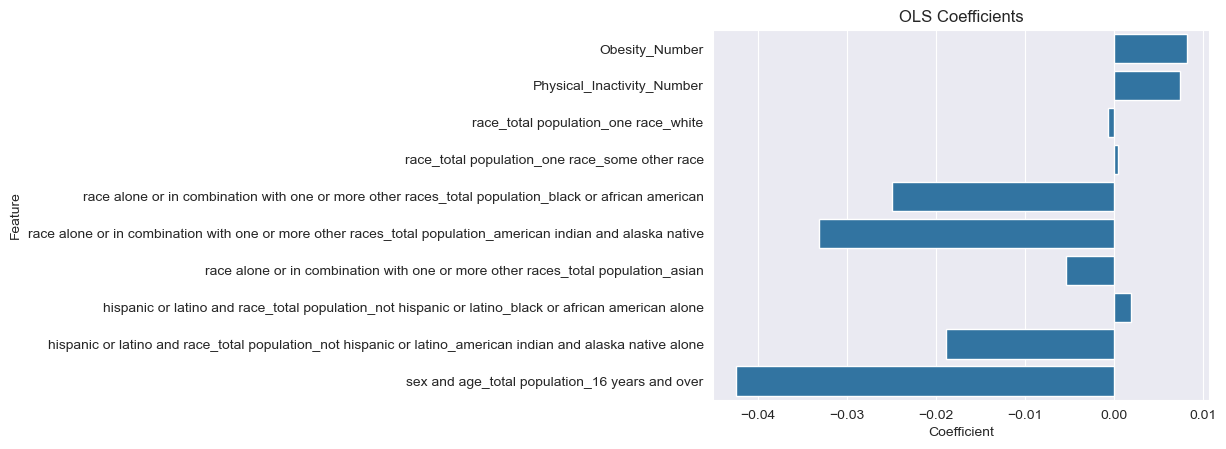

In [47]:
# Train the model
lin_model = LinearRegression()
lin_model.fit(X_train, y_train)

# create a dataframe with the coefficient and feature names for plotting
lin_reg_data = pd.DataFrame([lin_model.coef_, X_selected_final.columns]).T # make a dataframe from the arrays
lin_reg_data.columns = ['Coefficient', 'Feature']           # add column names for clarity

# plot
ax = sns.barplot(x="Coefficient",                           # add x 
                 y="Feature",                               # add y
                 data=lin_reg_data)                         # specify data

ax.set_title("OLS Coefficients")                            # set title
plt.show()                                                  # show plot

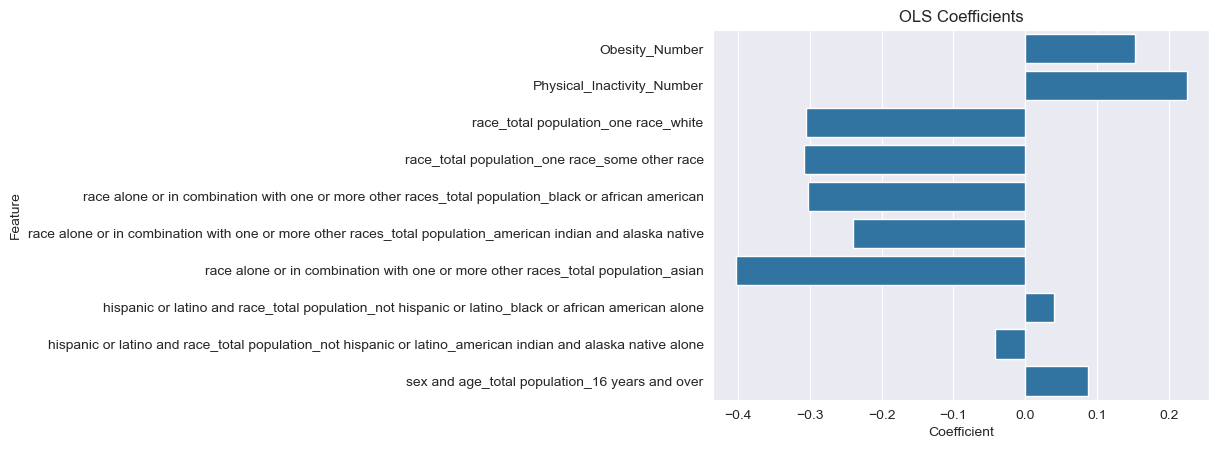

In [48]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(X_selected_final, 
                                                    y,
                                                    test_size=0.2,
                                                    train_size=0.8)
X_train2, X_validate2, y_train2, y_validate2 =  train_test_split(X_train2,
                                                    y_train2,
                                                    train_size=0.75,
                                                    test_size=0.25) 
# Train the model
lin_final_model = LinearRegression()
lin_final_model.fit(X_train2, y_train2)

# create a dataframe with the coefficient and feature names for plotting
lin_reg_data2 = pd.DataFrame([lin_final_model.coef_, X_selected_final.columns]).T
lin_reg_data2.columns = ['Coefficient', 'Feature']

# plot
ax = sns.barplot(x="Coefficient",                           # add x 
                 y="Feature",                               # add y
                 data=lin_reg_data2)                         # specify data

ax.set_title("OLS Coefficients")                            # set title
plt.show()                                                  # show plot

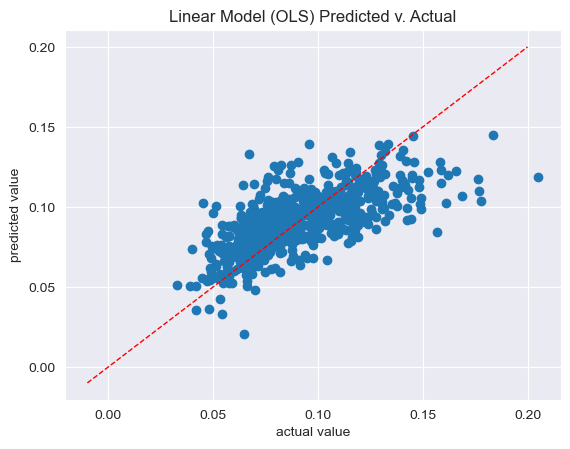

In [49]:
# evaluate the model
lin_final_pred = lin_final_model.predict(X_validate2)

# plot the residuals on a scatter plot
plt.scatter(y_validate2, lin_final_pred)                    # specify x and y of the scatter plot
plt.title('Linear Model (OLS) Predicted v. Actual')  # specify plot title
plt.xlabel('actual value')                           # specify x-axis label
plt.ylabel('predicted value')                        # specify y-axis label

# add a reference line for perfect prediction
plt.plot([-0.01, 0.2], [-0.01, 0.2], color='red', linestyle='--', linewidth=1)

plt.show()                                           # show plot

In [50]:
# calculate the rmse for the Linear model
rmse(lin_final_pred, y_validate)

0.032143410692029646

**Analysis**:

The results after applying RFE and retraining the model show an improvement in the alignment between predicted and actual values, as seen in the scatter plot. The RMSE has also decreased, indicating better model performance. 

This suggests that reducing the number of features and potentially mitigating multicollinearity has positively impacted the model’s predictive accuracy. However, the model still shows some deviation from the perfect prediction line, indicating that other factors might still influence the residual variance. 

### Ridge Pred

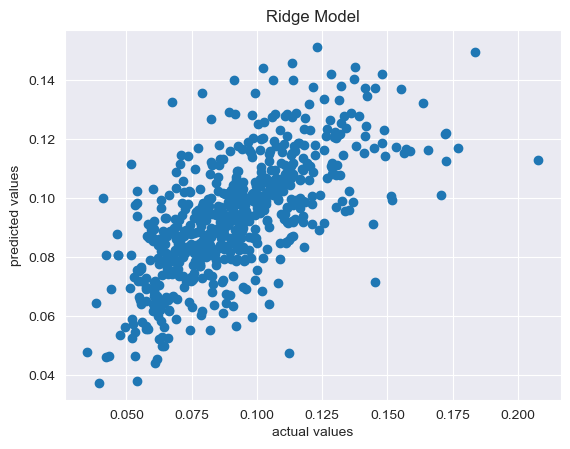

In [51]:
# use the model to make predictions
ridge_pred = ridge_model.predict(X_validate)

# plot the predictions
plt.scatter(y_validate, ridge_pred)
plt.title('Ridge Model')
plt.xlabel('actual values')
plt.ylabel('predicted values')
plt.show()

In [52]:
# calculate the rmse for the Ridge model
rmse(ridge_pred, y_validate)

0.0196619259410645

**Analysis:** The `rmse` for the Ridge regression is slightly smaller than for the linear regression, suggeting a better fit.

### Lass Pred

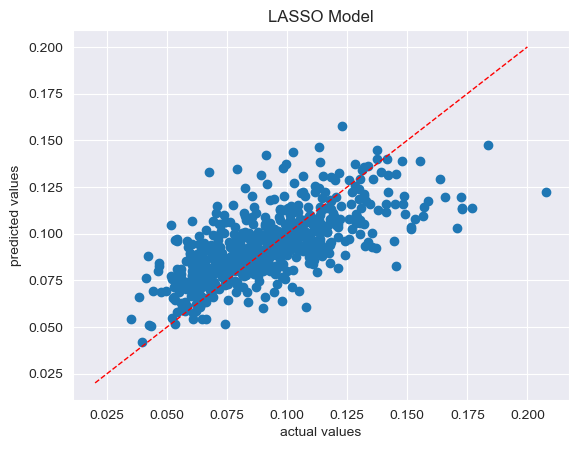

In [53]:
# use the model to make predictions
lasso_pred = lasso_model.predict(X_validate)

# plot the predictions
plt.scatter(y_validate, lasso_pred)

# add title and labels
plt.title('LASSO Model')
plt.xlabel('actual values')
plt.ylabel('predicted values')

# add a reference line for perfect prediction
plt.plot([0.02, 0.2], [0.02, 0.2], color='red', linestyle='--', linewidth=1)

plt.show()

In [54]:
# calculate the rmse for the LASSO model
rmse(lasso_pred, y_validate)

0.019481704490076968

### 5.2 Predict on the test set

Now, choose your best performing model of the three, select out unimportant feature(s), retrain the model, and then predict on the test set. 

In [55]:
#
# Predict using your best model
#-----------

In [56]:
# see parameters for linear regression
lin_reg.get_params()

{'copy_X': True, 'fit_intercept': True, 'n_jobs': None, 'positive': False}

In [57]:
# see parameters for Ridge regression
ridge_reg.get_params()

{'alpha': 1.0,
 'copy_X': True,
 'fit_intercept': True,
 'max_iter': None,
 'positive': False,
 'random_state': None,
 'solver': 'auto',
 'tol': 0.0001}

In [58]:
# see parameters for Lasso regression
lasso_reg.get_params()

{'alpha': 0.001,
 'copy_X': True,
 'fit_intercept': True,
 'max_iter': 15000,
 'positive': False,
 'precompute': False,
 'random_state': None,
 'selection': 'cyclic',
 'tol': 0.0001,
 'warm_start': False}

In [59]:
#
# Linear regression 
#-----------

# specify the hyperparameters
param_grid = {'fit_intercept': [True, False]}          # use dictionary for tuning

# execute the grid search
lin_grid_reg = GridSearchCV(estimator  = lin_reg,      # model to be tuned
                            param_grid = param_grid,   # parameters to be searched as specified above
                            cv=5)                      # 3-fold cross-validation to be used during hypertuning

# now fit the tuning on the training data
lin_grid_reg.fit(X_train2, y_train2)

# select the best performing model and predict with that on validation dataset
best_index = np.argmax(lin_grid_reg.cv_results_["mean_test_score"])  # find the best performing model
best_lin_pred = lin_grid_reg.best_estimator_.predict(X_validate2)     # find best estimator and predict on validate

# print the results  
print(lin_grid_reg.cv_results_["params"][best_index])
print('Best CV R^2:', max(lin_grid_reg.cv_results_["mean_test_score"]))
print('Validation R^2:', lin_grid_reg.score(X_validate2, y_validate2))
print('Validation RMSE', rmse(best_lin_pred, y_validate2))

{'fit_intercept': True}
Best CV R^2: 0.4620634207795999
Validation R^2: 0.45909504299139436
Validation RMSE 0.019817440064825928


In [60]:
#
# RIDGE 
#-----------

# specify the hyperparameters
param_grid = {'alpha': np.logspace(-2, 2, 60),
              'fit_intercept': [True, False],
              'solver': ['auto', 'svd', 'cholesky', 'lsqr']}

# execute the grid search
ridge_grid_reg = GridSearchCV(ridge_reg,  # model to be tuned
                              param_grid, # parameters to be searched as specified above
                              cv=5)       # 5-fold cross-validation to be used during hypertuning

# fit the tuning on the training data
ridge_grid_reg.fit(X_train, y_train)

# select the best performing model and predict with that on validation dataset 
best_index = np.argmax(ridge_grid_reg.cv_results_["mean_test_score"])  # find the best performing model
best_ridge_pred = ridge_grid_reg.best_estimator_.predict(X_validate)   # find best estimator and predict on validate

# print the results  
print(ridge_grid_reg.cv_results_["params"][best_index])
print('Best CV R^2:', max(ridge_grid_reg.cv_results_["mean_test_score"]))
print('Validation R^2:', ridge_grid_reg.score(X_validate, y_validate))
print('Validation RMSE', rmse(best_ridge_pred, y_validate))

{'alpha': 33.529241492495565, 'fit_intercept': True, 'solver': 'auto'}
Best CV R^2: 0.4926581115256095
Validation R^2: 0.4486969735548876
Validation RMSE 0.01932406523717965


In [61]:
#
# LASSO 
#----------- 

# specify the hyperparameters
param_grid = {'alpha': np.logspace(-5, 0, 60),
              'fit_intercept': [True, False],
              'selection': ['cyclic', 'random']}

# execute the grid search
lasso_grid_reg = GridSearchCV(lasso_reg,  # model to be tuned
                              param_grid, # parameters to be searched as specified above
                              cv=5)       # 3-fold cross-validation to be used during hypertuning

# now fit the tuning on the training data
lasso_grid_reg.fit(X_train, y_train)

# select the best performing model and predict with that on validation dataset 
best_index = np.argmax(lasso_grid_reg.cv_results_["mean_test_score"])   # find the best performing model
best_lasso_pred = lasso_grid_reg.best_estimator_.predict(X_validate)    # find best estimator and predict on validate

# print results
print(lasso_grid_reg.cv_results_["params"][best_index])
print('Best CV R^2:', max(lasso_grid_reg.cv_results_["mean_test_score"]))
print('Validation R^2:', lasso_grid_reg.score(X_validate, y_validate))
print('Validation RMSE', rmse(best_lasso_pred, y_validate))

{'alpha': 7.038135554931547e-05, 'fit_intercept': True, 'selection': 'random'}
Best CV R^2: 0.4921005316222825
Validation R^2: 0.45068991581812934
Validation RMSE 0.01928910568482419


### 5.3 Impement a cross-validation approach

Finally, implement a cross-validation approach for your best model and evaluate the results.

In [62]:
#
# Run cross-validation
#-----------
best_model = lasso_grid_reg.best_estimator_

# Perform cross-validation using R^2
cv_scores = cross_val_score(best_model,
                            X,
                            y.ravel(),
                            cv=5,
                            scoring='r2')
print(f"Cross-Validation R^2 scores: {cv_scores}")
print(f"Average CV R^2: {cv_scores.mean()}")

# Perform cross-validation using RMSE
rmse_scorer = make_scorer(rmse, greater_is_better=False)
cv_rmse_scores = cross_val_score(best_model,
                            X,
                            y.ravel(),
                            cv=5,
                            scoring=rmse_scorer)
print(f"Cross-Validation RMSE scores: {cv_rmse_scores}")
print(f"Average CV RMSE: {cv_rmse_scores.mean()}")

/var/folders/gz/txr1ywf13ss49jh8_z6ygy4h0000gn/T/ipykernel_84102/275027036.py:9: FutureWarning:

Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.



Cross-Validation R^2 scores: [0.51806826 0.32142119 0.45865065 0.40778922 0.46365614]
Average CV R^2: 0.43391709317157223


/var/folders/gz/txr1ywf13ss49jh8_z6ygy4h0000gn/T/ipykernel_84102/275027036.py:19: FutureWarning:

Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.



Cross-Validation RMSE scores: [-0.02349639 -0.01978767 -0.01758903 -0.02083523 -0.02129654]
Average CV RMSE: -0.02060096999030525


In [63]:
# Best LASSO model

# pick the best estimator and predict on test
best_pred = best_model.predict(X_test)

# print various results
print('Best CV R^2:', max(lasso_grid_reg.cv_results_["mean_test_score"]))
print('Test R^2:', lasso_grid_reg.score(X_test, y_test))
print('Test RMSE', rmse(best_pred, y_test))

Best CV R^2: 0.4921005316222825
Test R^2: 0.45603097898587663
Test RMSE 0.020327439876797818


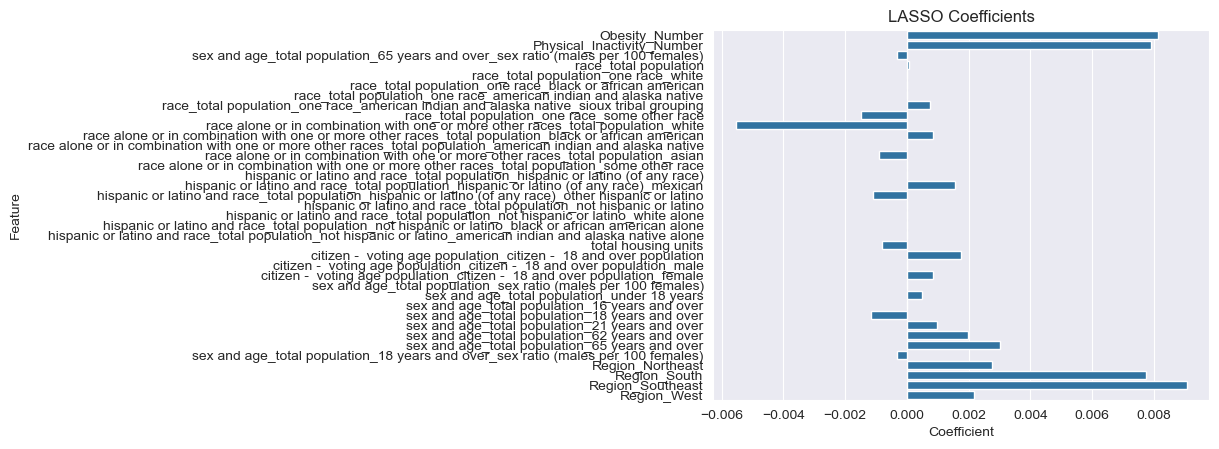

In [65]:
# create a dataframe with the coefficient and feature names for plotting
best_reg_data = pd.DataFrame([best_model.coef_, X_test.columns]).T
best_reg_data.columns = ['Coefficient', 'Feature']

# plot
ax = sns.barplot(x="Coefficient",                           # add x 
                 y="Feature",                               # add y
                 data=best_reg_data)                         # specify data

ax.set_title("LASSO Coefficients")                            # set title
plt.show()                                                  # show plot

**Interpretation of Results**:  

1. Positive Coefficients:
- The positive coefficients on the right side indicate features that are positively associated with diabetes rates. For instance, Obesity_Number, Physical_Inactivity_Number, and Region_Southeast show strong positive coefficients, suggesting they are the most influential factors, which aligns with known risk factors for diabetes.
- Among demographic factors, the proportion of Black or African American populations also has a positive coefficient, reflecting an elevated risk of diabetes, though it is less influential than obesity or inactivity. Conversely, the proportion of Asian populations shows a negative coefficient, suggesting a lower association with diabetes rates.
- Age Variables: As shown in the plot, age-related variables demonstrate an increasing positive coefficient as the age group rises. This trend indicates that older age groups are associated with higher diabetes rates.
2. Negative Coefficients:
- The negative coefficients on the left side represent features that are negatively associated with diabetes rates. For example, sex and age_total population_65 years and over_sex ratio (males per 100 females) and Region_South display negative coefficients, implying that increases in these features are related to lower diabetes rates.
3. Feature Sparsity:
- Due to the nature of the LASSO regression, it shrinks less important feature coefficients toward zero. This indicates that the model has effectively selected the most relevant features and ignored less significant ones.

In summary, this analysis aligns with known health patterns, where aging, obesity, and physical inactivity are critical factors in diabetes prevalence. The LASSO model effectively emphasizes these relationships, highlighting the need for targeted interventions in specific age groups and regions.

## 6. Discussion Questions

In this section, insert responses for discussion questions here.

**1. What is bias-variance tradeoff? Why is it relevant to machine learning problems like this one?**

The bias-variance tradeoff is a fundamental concept in machine learning that refers to the balance between two sources of error when training a model:  

**Bias**: The error due to overly simplistic models that fail to capture the underlying patterns of the data (underfitting). High bias models tend to miss relevant relationships.  
**Variance**: The error due to overly complex models that capture noise as if it were a true pattern (overfitting). High variance models fail to generalize well to new, unseen data.

This tradeoff is crucial for models like the ones in this analysis (Linear Regression, Ridge, and LASSO). In this project, LASSO was particularly useful because it minimizes overfitting by shrinking less important coefficients to zero, improving the model’s generalization.

**2. Define overfitting, and why it matters for machine learning. How can we address it?**

Overfitting happens when a model fits the training data too well, including noise, resulting in poor performance on new data. It is problematic because it results in low training error but high test error, indicating that the model does not generalize well. 

In this analysis, we used techniques such as cross-validation, Ridge, and LASSO regression to mitigate overfitting. Regularization techniques (Ridge and LASSO) add penalties to model complexity, while cross-validation helps ensure the model performs consistently across different data subsets.

Notably, in this project, the LASSO model uses a very low penalty, which could impact the bias-variance tradeoff. Specifically, the low penalty reduces the regularization strength, allowing more features to be retained and thus decreasing model bias. However, this might also increase model variance, as it could capture noise in the training data, potentially leading to overfitting. While this setup helps preserve important features for predicting diabetes rates, it requires careful balancing between bias and variance. Using cross-validation to select an optimal penalty can help minimize the risk of overfitting while ensuring good generalization to unseen data.

**3. Discuss your analysis in 2-3 paragraphs. Discuss your findings and recommendations. Which counties or regions would you prioritize for the pilot program? Would your answers change based on whether you want to take into account certain features such as race, gender, or age composition in the county? How confident would you be deploying this sort of model in a real-world application – why or why not?**

The analysis revealed that obesity, physical inactivity, and region are strong predictors of diabetes rates across U.S. counties. Diabetes risk increases with age, which is clearly reflected in county-level data where older populations show higher diabetes rates. Geographic patterns also reveal that the Southern and Southeastern U.S. have notably higher diabetes prevalence. This aligns with known health disparities and emphasizes the importance of lifestyle and regional factors in diabetes prevalence. The LASSO model performed the best among the models tested, with reasonable R² and RMSE scores on both the validation and test sets, suggesting a decent balance between fit and generalization.

For the pilot program, I would recommend focusing on counties with high obesity and physical inactivity rates, as these factors showed the strongest association with diabetes rates. Priority regions could include the Western and Southern regions, where diabetes prevalence is typically higher. If demographic factors like race, gender, or age are considered, it could lead to more nuanced targeting. For instance, areas with higher proportions of Black or Hispanic populations may require tailored interventions, as these groups often face greater barriers to healthcare access.

While the model shows good predictive ability, deploying it in a real-world application for intervention planning should be approached critically, with attention to potential biases, ethical implications, and the risk of reinforcing existing inequalities. The relationships among nonwhite populations and diabetes are not new. However, the higher diabetes rates among nonwhite populations do not stem solely from physical differences but are influenced by a range of factors such as socioeconomic disadvantage, limited healthcare access, lack of health education, and barriers to a healthy diet. Historically, Native Americans and Alaska Natives have had some of the highest diabetes rates, driven by genetic predisposition, dietary changes, and unequal healthcare access. Additionally, confounding factors like income, education, and healthcare accessibility, which are often linked to race, could also affect diabetes prevalence, potentially complicating the observed relationships in the analysis. Variables such as socioeconomic status and access to healthcare, which weren’t fully accounted for, could impact the model’s accuracy. Additionally, ethical considerations about data use and fairness must be addressed to ensure that interventions do not inadvertently reinforce existing disparities. Overall, with further refinement and validation, this model could be a useful tool in identifying areas most in need of targeted diabetes interventions.